In [3]:
#%% Add to path
import sys
%cd ..

with open('python_paths.txt', 'r') as f:
    paths = f.read().splitlines()
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

        
print(sys.path)
print(sys.executable)

/media/theodore/HDD1/These/projets/3d_segm
['/media/theodore/HDD1/These/projets/3d_segm/Notebooks', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/SimpleITK-1.2.0rc2.dev1162+g2a79d-py3.7-linux-x86_64.egg', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/IPython/extensions', '/home/theodore/.ipython', './', '/media/theodore/HDD1/These/projets/3d_segm']
/media/theodore/HDD1/Spondi/SpondiDetect/venv/bin/python3


In [15]:
import random
from importlib import reload
from time import time
from os.path import join
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import skimage.morphology as morp

import all_paths as ap
reload(ap)
import src.data_manager.utils as du
import src.data_manager.get_data as gd
import src.plotter as p

def reload_modules():
    for mudl in [p, du, gd]:
        reload(mudl)
        
reload_modules()

print('Done.')

Done.


In [5]:
def get_segm_atlas(parent=ap.all_paths["atlas_nibs"], patient="hoang"):
    sacrum = nib.load(join(parent, patient, f"3D{patient}-sacrum.nii")).get_fdata()
    iliaque = nib.load(join(parent, patient, f"3D{patient}-iliaque.nii")).get_fdata()

    sacrum[iliaque.astype(bool)] = 2
    
    return sacrum

def get_vol_atlas(parent=ap.all_paths["atlas_nibs"], patient="hoang"):
    return nib.load(join(parent, patient, f"3D{patient}.nii")).get_fdata()
    

In [8]:
seg3d = get_segm_atlas()
vol = get_vol_atlas()

print(seg3d.shape, vol.shape)


(384, 384, 192) (384, 384, 192)


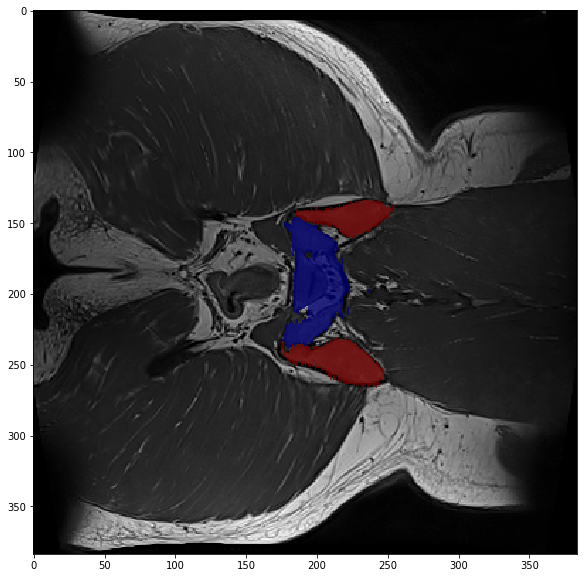

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p.plot_img_mask_on_ax(ax, vol[..., 150], seg3d[..., 150])

# Wrapping

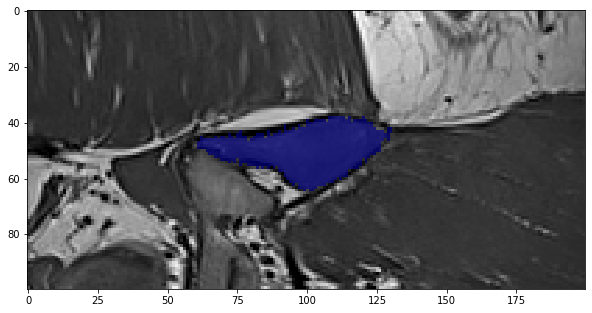

In [16]:
reload_modules()

slice_idx = 150
img = vol[..., slice_idx]
seg = morp.label(seg3d[..., slice_idx] == 2) == 1

img = du.center_and_crop(img, seg, (100, 200))
seg = du.center_and_crop(seg, seg, (100, 200))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
p.plot_img_mask_on_ax(ax, img, seg)

In [61]:
n_slices = 7
margin = .1 * img.shape[0]

all_slices = np.where(seg.sum(0))[0]
# label_slices = random.sample(list(all_slices), n_slices)
label_slices = np.linspace(all_slices.min() + 1, all_slices.max() - 1, n_slices).astype(int)
segl = np.zeros_like(seg)
segl[:, label_slices] = seg[:, label_slices]

markers = segl + 0
for slice_idx in label_slices:
    slce = segl[:, slice_idx]
    xls = np.where(slce != 0)[0]
    markers[:xls.min() - int(margin / 2), slice_idx] = -1
    markers[xls.max() + int(margin / 2):, slice_idx] = -1

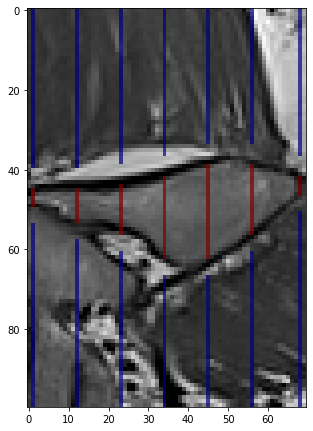

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
p.plot_img_mask_on_ax(ax, img[:, all_slices], markers[:, all_slices])

In [63]:
reload_modules()
grad_img = np.abs(du.grad_img(img))
labels = morp.watershed(grad_img, markers)


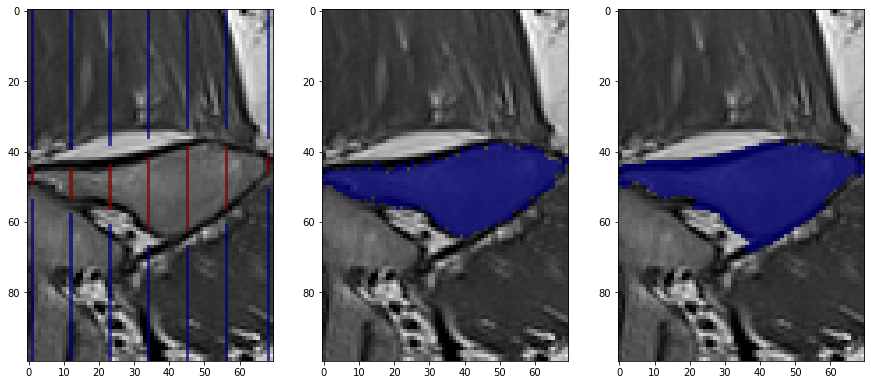

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
p.plot_img_mask_on_ax(axs[0], img[:, all_slices], markers[:, all_slices])
p.plot_img_mask_on_ax(axs[1], img[:, all_slices], seg[:, all_slices])
p.plot_img_mask_on_ax(axs[2], img[:, all_slices], labels[:, all_slices] == 1)